In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks"


 ccmb.ipynb				        IIT_HYD_FINAL.csv
'Copy of Assignment_4.ipynb'		        IIT_PHD.csv
'Copy of Copy of Assignment_1 (1).ipynb'        IIT_PHD.gsheet
'Copy of Copy of Assignment_1.ipynb'	        merged_faculty_salary.csv
'Copy of Copy of Assignment_2.ipynb'	        name_matching_report.csv
'Copy of Copy of Assignment_4.ipynb'	        NAMES.csv
'Copy of Hazil Harris - Assignment_6.ipynb'     NOMR_SAL.csv
'Copy of Hazil Harris - Exam_Session_6.ipynb'   prediction_ML.ipynb
 DATACOMBINED_V1.csv			       'solutions of midsem.ipynb'
 DS_project.ipynb			        TEST.csv
 Facultysalary.csv			        TEST-IISERK.csv
 FINAL.csv				        TEST_IISERM.csv
 Get_citations.ipynb			        Untitled
'Hazil Harris ms23182'			        Untitled0.ipynb
'Hazilms23182 (assignment.2)'		        Untitled1.ipynb


SALARY PREDICTION MODEL: PhD Institution → Working Institution → Salary

[1] Loading Data...
✓ Loaded faculty data: (926, 3)
✓ Loaded salary data: (622, 4)

Faculty Data Preview:
                     NAME     INSTITUTE   \
0  Aalok Dinkar Khandekar  IIT HYDERABAD   
1        Aardra Surendran  IIT HYDERABAD   
2             Abhijit Das  IIT HYDERABAD   
3             Abhijit Sau  IIT HYDERABAD   
4           Abhinav Kumar  IIT HYDERABAD   

                                       PHD  
0         Rensselaer Polytechnic Institute  
1  Jawaharlal Nehru University, New Delhi.  
2                             IIT Guwahati  
3                  Bose Institute, Kolkata  
4                                IIT Delhi  

Salary Data Preview:
                     NAME      INSTITUTE  \
0  Aalok Dinkar Khandekar  IIT HYDERABAD   
1  Aalok Dinkar Khandekar  IIT HYDERABAD   
2        Aardra Surendran  IIT HYDERABAD   
3        Aardra Surendran  IIT HYDERABAD   
4             Abhijit Sau  IIT HYDERABAD   


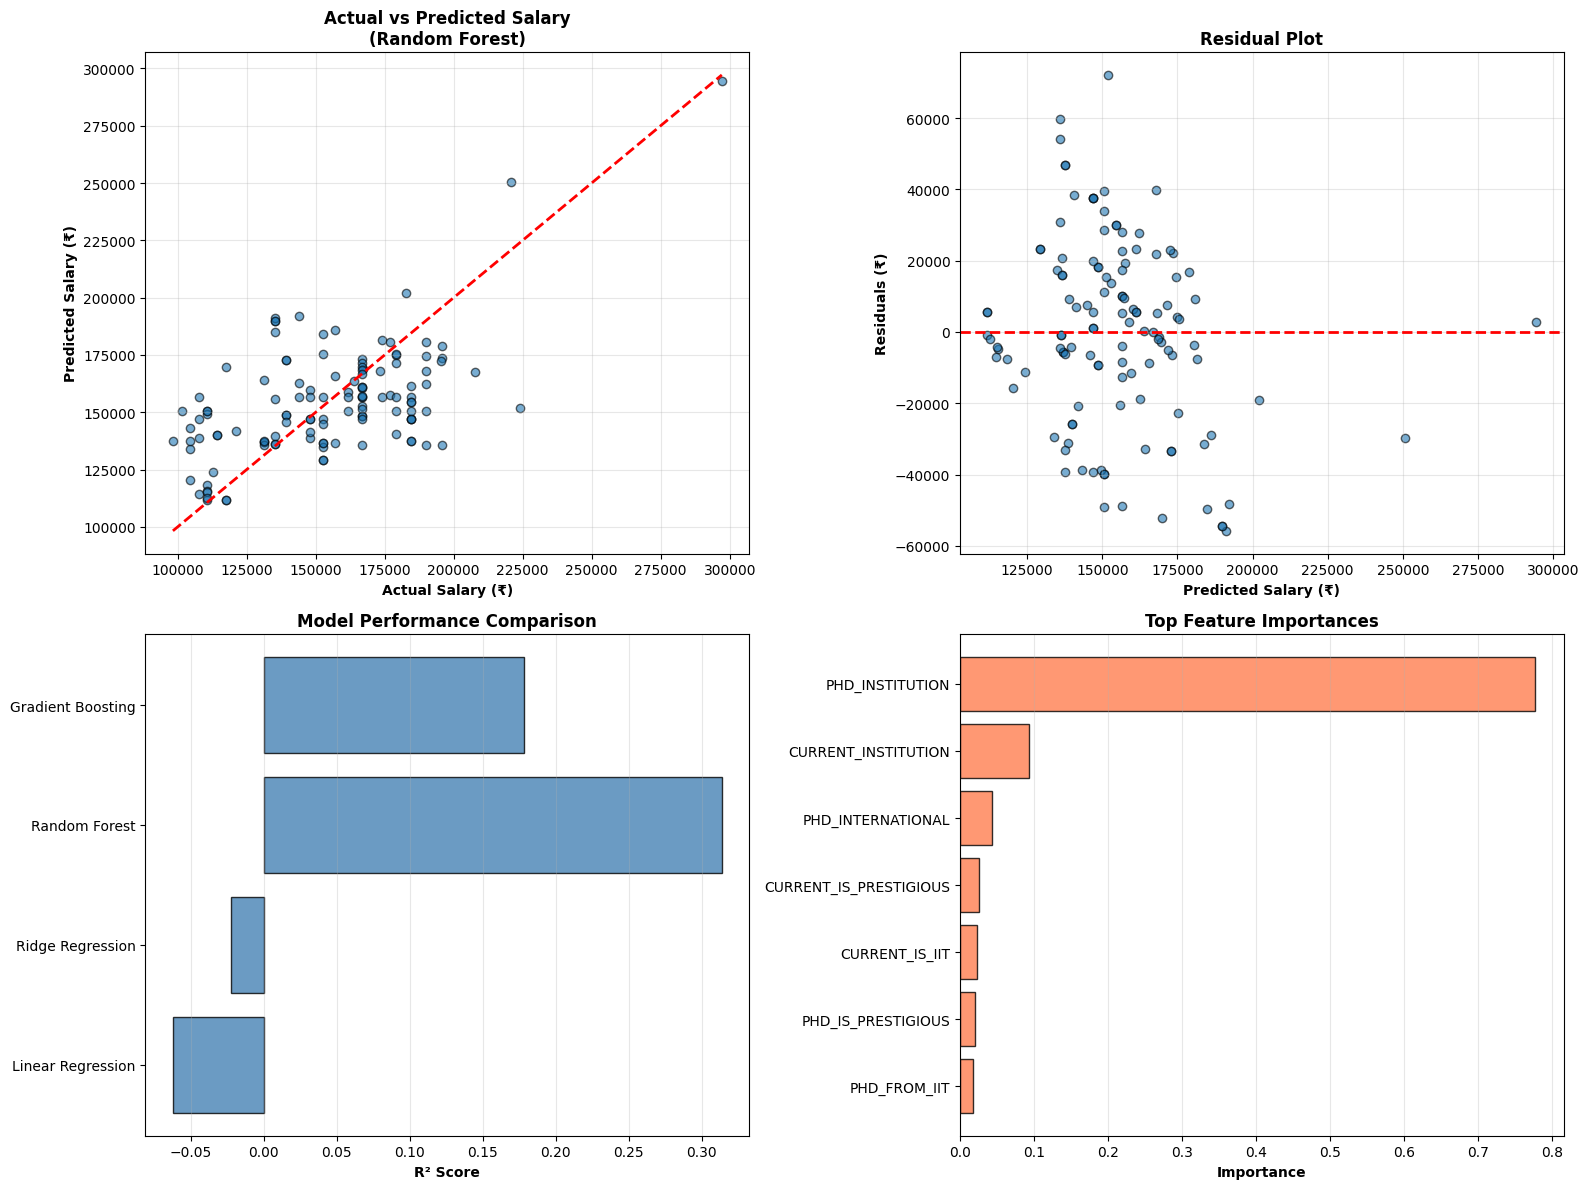

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("SALARY PREDICTION MODEL: PhD Institution → Working Institution → Salary")
print("="*70)


print("\n[1] Loading Data...")


faculty_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATACOMBINED_V1.csv')
print(f" Loaded faculty data: {faculty_df.shape}")


salary_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NORM_SAL.csv')
print(f" Loaded salary data: {salary_df.shape}")

print("\nFaculty Data Preview:")
print(faculty_df.head())
print("\nSalary Data Preview:")
print(salary_df.head())


print("\n[2] Cleaning and Standardizing Data...")


faculty_df = faculty_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
salary_df = salary_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)


faculty_df.columns = faculty_df.columns.str.upper().str.strip()
salary_df.columns = salary_df.columns.str.upper().str.strip()

print(f"Faculty columns: {faculty_df.columns.tolist()}")
print(f"Salary columns: {salary_df.columns.tolist()}")


print("\n[3] Merging Datasets...")


merged_df = faculty_df.merge(
    salary_df[['NAME', 'PAY', 'INSTITUTE']],
    on=['NAME', 'INSTITUTE'],
    how='inner'
)

print(f" Merged dataset shape: {merged_df.shape}")
print(f" Columns: {merged_df.columns.tolist()}")

if len(merged_df) == 0:
    print("\n ERROR: No matching records found!")
    print("\n Trying alternative merge strategy (by NAME only)...")


    merged_df = faculty_df.merge(
        salary_df[['NAME', 'PAY', 'INSTITUTE']],
        on='NAME',
        how='inner',
        suffixes=('_FACULTY', '_SALARY')
    )

    print(f" Alternative merge result: {merged_df.shape}")

    if len(merged_df) == 0:
        print("\n Still no matches. Check if NAME values match in both files.")
        print("\nSample names from faculty file:")
        print(faculty_df['NAME'].head(10).tolist())
        print("\nSample names from salary file:")
        print(salary_df['NAME'].head(10).tolist())
        exit()


print("\n[4] Preparing Data for ML...")


merged_df = merged_df.dropna(subset=['PAY', 'PHD'])


merged_df['PAY'] = merged_df['PAY'].astype(str).str.replace('[₹$,\s]', '', regex=True)
merged_df['PAY'] = pd.to_numeric(merged_df['PAY'], errors='coerce')
merged_df = merged_df.dropna(subset=['PAY'])


Q1 = merged_df['PAY'].quantile(0.25)
Q3 = merged_df['PAY'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
merged_df = merged_df[(merged_df['PAY'] >= lower_bound) & (merged_df['PAY'] <= upper_bound)]

print(f" Final dataset shape: {merged_df.shape}")
print(f"\n Salary Statistics:")
print(merged_df['PAY'].describe())
print(f"\nMin Salary: ₹{merged_df['PAY'].min():,.2f}")
print(f"Max Salary: ₹{merged_df['PAY'].max():,.2f}")
print(f"Mean Salary: ₹{merged_df['PAY'].mean():,.2f}")
print(f"Median Salary: ₹{merged_df['PAY'].median():,.2f}")


print("\n[5] Feature Engineering...")


if 'INSTITUTE_FACULTY' in merged_df.columns:
    current_inst_col = 'INSTITUTE_FACULTY'
elif 'INSTITUTE_SALARY' in merged_df.columns:
    current_inst_col = 'INSTITUTE_SALARY'
else:
    current_inst_col = 'INSTITUTE'

print(f" Using current institution column: {current_inst_col}")


features_df = pd.DataFrame()


features_df['PHD_INSTITUTION'] = merged_df['PHD']
features_df['CURRENT_INSTITUTION'] = merged_df[current_inst_col]


prestige_keywords = ['IIT', 'IISc', 'MIT', 'Stanford', 'Harvard', 'Cambridge', 'Oxford',
                     'Berkeley', 'Caltech', 'Princeton', 'Yale', 'Columbia']

def check_prestige(institution):
    if pd.isna(institution):
        return 0
    institution = str(institution).upper()
    for keyword in prestige_keywords:
        if keyword.upper() in institution:
            return 1
    return 0

features_df['PHD_IS_PRESTIGIOUS'] = merged_df['PHD'].apply(check_prestige)
features_df['CURRENT_IS_PRESTIGIOUS'] = merged_df[current_inst_col].apply(check_prestige)


features_df['PHD_FROM_IIT'] = merged_df['PHD'].str.contains('IIT', case=False, na=False).astype(int)
features_df['CURRENT_IS_IIT'] = merged_df[current_inst_col].str.contains('IIT', case=False, na=False).astype(int)


features_df['IS_INBRED'] = (merged_df['PHD'] == merged_df[current_inst_col]).astype(int)


intl_keywords = ['USA', 'UK', 'Europe', 'America', 'University of', 'MIT', 'Stanford',
                 'Harvard', 'Cambridge', 'Oxford']
def is_international(institution):
    if pd.isna(institution):
        return 0
    institution = str(institution)
    for keyword in intl_keywords:
        if keyword in institution:
            return 1
    return 0

features_df['PHD_INTERNATIONAL'] = merged_df['PHD'].apply(is_international)


target = merged_df['PAY']

print(f" Created {len(features_df.columns)} features:")
for i, col in enumerate(features_df.columns, 1):
    print(f"   {i}. {col}")


print("\n[6] Encoding Categorical Variables...")

features_encoded = features_df.copy()
label_encoders = {}

categorical_cols = ['PHD_INSTITUTION', 'CURRENT_INSTITUTION']

for col in categorical_cols:
    le = LabelEncoder()
    features_encoded[col] = le.fit_transform(features_df[col].astype(str))
    label_encoders[col] = le
    print(f" Encoded {col}: {len(le.classes_)} unique values")


phd_institutions = sorted(features_df['PHD_INSTITUTION'].unique())
current_institutions = sorted(features_df['CURRENT_INSTITUTION'].unique())

print(f"\n PhD Institutions in dataset: {len(phd_institutions)}")
print(f" Current Institutions in dataset: {len(current_institutions)}")


print("\n[7] Splitting Data...")

X = features_encoded
y = target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f" Training set: {X_train.shape[0]} samples")
print(f" Test set: {X_test.shape[0]} samples")


print("\n[8] Training Models...")

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=10.0),
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42,
                                           max_depth=15, min_samples_split=5),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42,
                                                    max_depth=7, learning_rate=0.1)
}

results = {}

for name, model in models.items():
    print(f"\n   Training {name}...")


    model.fit(X_train, y_train)


    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)


    mae = mean_absolute_error(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)

    results[name] = {
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'r2_train': r2_train,
        'predictions': y_pred_test
    }

    print(f"   Train R: {r2_train:.4f}")
    print(f"   Test R: {r2:.4f}")
    print(f"   MAE: ₹{mae:,.2f}")
    print(f"   RMSE: ₹{rmse:,.2f}")


print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'R² (Test)': [results[m]['r2'] for m in results.keys()],
    'R² (Train)': [results[m]['r2_train'] for m in results.keys()],
    'MAE': [results[m]['mae'] for m in results.keys()],
    'RMSE': [results[m]['rmse'] for m in results.keys()]
})
print(comparison_df.to_string(index=False))

best_model_name = max(results.keys(), key=lambda k: results[k]['r2'])
best_model = results[best_model_name]['model']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   Test R Score: {results[best_model_name]['r2']:.4f}")
print(f"   Train R Score: {results[best_model_name]['r2_train']:.4f}")
print(f"   MAE: ₹{results[best_model_name]['mae']:,.2f}")
print(f"   RMSE: ₹{results[best_model_name]['rmse']:,.2f}")


if hasattr(best_model, 'feature_importances_'):
    print("\n" + "="*70)
    print("FEATURE IMPORTANCE")
    print("="*70)

    importances = best_model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print(feature_importance.to_string(index=False))


print("\n" + "="*70)
print("PREDICTION FUNCTION")
print("="*70)

def predict_salary(phd_institution, current_institution):
    """
    Predict salary for a person with PhD from X working at institution Y

    Parameters:
    -----------
    phd_institution : str
        Name of PhD institution (e.g., "IIT Delhi")
    current_institution : str
        Name of current working institution (e.g., "IIT Bombay")

    Returns:
    --------
    dict : Predicted salary and confidence interval
    """


    phd_prestige = check_prestige(phd_institution)
    current_prestige = check_prestige(current_institution)


    phd_iit = 1 if 'IIT' in str(phd_institution).upper() else 0
    current_iit = 1 if 'IIT' in str(current_institution).upper() else 0


    is_inbred = 1 if phd_institution == current_institution else 0


    intl_keywords = ['USA', 'UK', 'Europe', 'America', 'University of', 'MIT', 'Stanford',
                 'Harvard', 'Cambridge', 'Oxford']
    def is_international(institution):
        if pd.isna(institution):
            return 0
        institution = str(institution)
        for keyword in intl_keywords:
            if keyword in institution:
                return 1
        return 0

    phd_intl = is_international(phd_institution)


    new_data = {
        'PHD_INSTITUTION': phd_institution,
        'CURRENT_INSTITUTION': current_institution,
        'PHD_IS_PRESTIGIOUS': phd_prestige,
        'CURRENT_IS_PRESTIGIOUS': current_prestige,
        'PHD_FROM_IIT': phd_iit,
        'CURRENT_IS_IIT': current_iit,
        'IS_INBRED': is_inbred,
        'PHD_INTERNATIONAL': phd_intl
    }


    new_df = pd.DataFrame([new_data])


    for col in categorical_cols:
        le = label_encoders[col]
        try:
            new_df[col] = le.transform(new_df[col].astype(str))
        except ValueError:

            new_df[col] = len(le.classes_) // 2
            print(f"   Warning: {col} '{new_data[col]}' not in training data. Using default encoding.")


    predicted_salary = best_model.predict(new_df)[0]


    if hasattr(best_model, 'estimators_'):
        predictions = []
        for estimator in best_model.estimators_:
            if hasattr(estimator, 'predict'):
                pred = estimator.predict(new_df)[0]
            else:
                pred = estimator[0].predict(new_df)[0]
            predictions.append(pred)

        std_dev = np.std(predictions)
        lower_bound = predicted_salary - 1.96 * std_dev
        upper_bound = predicted_salary + 1.96 * std_dev
    else:

        rmse = results[best_model_name]['rmse']
        lower_bound = predicted_salary - 1.96 * rmse
        upper_bound = predicted_salary + 1.96 * rmse

    return {
        'predicted_salary': predicted_salary,
        'lower_bound': max(0, lower_bound),
        'upper_bound': upper_bound,
        'features': new_data
    }

print(" Prediction function ready!")


print("\n" + "="*70)
print("EXAMPLE PREDICTIONS")
print("="*70)


if len(phd_institutions) > 0 and len(current_institutions) > 0:
    example_phd = phd_institutions[0]
    example_current = current_institutions[0]

    print(f"\n Example 1: PhD from '{example_phd}' Working at '{example_current}'")
    result = predict_salary(example_phd, example_current)
    print(f"   Predicted Salary: ₹{result['predicted_salary']:,.2f}")
    print(f"   95 Confidence Interval: ₹{result['lower_bound']:,.2f} - ₹{result['upper_bound']:,.2f}")


if any('IIT' in inst for inst in phd_institutions):
    iit_phds = [inst for inst in phd_institutions if 'IIT' in inst]
    iit_currents = [inst for inst in current_institutions if 'IIT' in inst]

    if len(iit_phds) > 0 and len(iit_currents) > 0:
        print(f"\n Example 2: PhD from '{iit_phds[0]}' Working at '{iit_currents[0]}'")
        result = predict_salary(iit_phds[0], iit_currents[0])
        print(f"   Predicted Salary: ₹{result['predicted_salary']:,.2f}")
        print(f"   95 Confidence Interval: ₹{result['lower_bound']:,.2f} - ₹{result['upper_bound']:,.2f}")


print("\n[13] Generating Visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))


axes[0, 0].scatter(y_test, results[best_model_name]['predictions'], alpha=0.6, edgecolors='k')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Salary (₹)', fontweight='bold')
axes[0, 0].set_ylabel('Predicted Salary (₹)', fontweight='bold')
axes[0, 0].set_title(f'Actual vs Predicted Salary\n({best_model_name})', fontweight='bold')
axes[0, 0].grid(alpha=0.3)


residuals = y_test - results[best_model_name]['predictions']
axes[0, 1].scatter(results[best_model_name]['predictions'], residuals, alpha=0.6, edgecolors='k')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Salary (₹)', fontweight='bold')
axes[0, 1].set_ylabel('Residuals (₹)', fontweight='bold')
axes[0, 1].set_title('Residual Plot', fontweight='bold')
axes[0, 1].grid(alpha=0.3)


model_names = list(results.keys())
r2_scores = [results[m]['r2'] for m in model_names]
axes[1, 0].barh(model_names, r2_scores, color='steelblue', alpha=0.8, edgecolor='black')
axes[1, 0].set_xlabel('R² Score', fontweight='bold')
axes[1, 0].set_title('Model Performance Comparison', fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)


if hasattr(best_model, 'feature_importances_'):
    top_features = feature_importance.head(7)
    axes[1, 1].barh(top_features['Feature'], top_features['Importance'],
                    color='coral', alpha=0.8, edgecolor='black')
    axes[1, 1].set_xlabel('Importance', fontweight='bold')
    axes[1, 1].set_title('Top Feature Importances', fontweight='bold')
    axes[1, 1].invert_yaxis()
    axes[1, 1].grid(axis='x', alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Feature importance\nnot available for\nthis model type',
                    ha='center', va='center', fontsize=12)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('salary_prediction_analysis.png', dpi=300, bbox_inches='tight')
print(" Saved: salary_prediction_analysis.png")


print("\n[14] Saving Model...")

import pickle

model_data = {
    'model': best_model,
    'model_name': best_model_name,
    'label_encoders': label_encoders,
    'feature_names': X.columns.tolist(),
    'performance': {
        'r2': results[best_model_name]['r2'],
        'mae': results[best_model_name]['mae'],
        'rmse': results[best_model_name]['rmse']
    },
    'phd_institutions': phd_institutions,
    'current_institutions': current_institutions
}

with open('salary_prediction_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print(" Saved: salary_prediction_model.pkl")


print("\n" + "="*70)
print("READY FOR PREDICTIONS!")
print("="*70)
print("\nUse the predict_salary() function:")
print("   predict_salary('IIT Delhi', 'IIT Bombay')")
print("\nAvailable PhD Institutions:")
for i, inst in enumerate(phd_institutions[:10], 1):
    print(f"   {i}. {inst}")
if len(phd_institutions) > 10:
    print(f"   ... and {len(phd_institutions) - 10} more")

print("\nAvailable Current Institutions:")
for i, inst in enumerate(current_institutions[:10], 1):
    print(f"   {i}. {inst}")
if len(current_institutions) > 10:
    print(f"   ... and {len(current_institutions) - 10} more")

print("\n MODEL TRAINING COMPLETE!")

In [ ]:
import joblib
model = joblib.load("salary_prediction_model.pkl")


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NORM_SAL.csv")


X = df.drop("PAY", axis=1)
y = df["PAY"]



In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 76.7 MB/s eta 0:00:00


In [ ]:
!pip install -q streamlit pandas numpy scikit-learn matplotlib seaborn pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.7 MB/s eta 0:00:00


In [ ]:
!pip install -q streamlit pandas numpy scikit-learn matplotlib seaborn pyngrok


In [ ]:
from google.colab import files
import pandas as pd

print(" Upload NORM_SAL.csv")
uploaded = files.upload()

if 'NORM_SAL.csv' in uploaded:
    print(" File uploaded!")
    df = pd.read_csv('NORM_SAL.csv')
    print(f"Shape: {df.shape}")
    print(df.head())

📂 Upload NORM_SAL.csv


Saving NORM_SAL.csv to NORM_SAL (1).csv


In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

st.set_page_config(page_title="Faculty Salary Predictor", page_icon="", layout="wide")

st.markdown("""
<style>
.main-header {font-size: 48px; font-weight: bold; text-align: center; color: #1f77b4; margin-bottom: 30px;}
.prediction-box {background-color: #e8f4f8; padding: 30px; border-radius: 10px; border-left: 5px solid #1f77b4; margin: 20px 0;}
.salary-amount {font-size: 48px; font-weight: bold; color: #27ae60; text-align: center;}
</style>
""", unsafe_allow_html=True)

st.markdown('<p class="main-header"> Faculty Salary Prediction System</p>', unsafe_allow_html=True)

def load_data():
    try:
        df = pd.read_csv('NORM_SAL.csv')
        df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
        df.columns = df.columns.str.upper().str.strip()
        df = df.dropna(subset=['PHD', 'INSTITUTE', 'PAY'])
        df['PAY'] = df['PAY'].astype(str).str.replace('[₹$,\\\\s]', '', regex=True)
        df['PAY'] = pd.to_numeric(df['PAY'], errors='coerce')
        df = df.dropna(subset=['PAY'])
        Q1, Q3 = df['PAY'].quantile(0.25), df['PAY'].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df['PAY'] >= Q1 - 3*IQR) & (df['PAY'] <= Q3 + 3*IQR)]
        return df
    except Exception as e:
        st.error(f"Error loading data: {e}")
        return None

def train_model(df):
    if df is None or len(df) == 0:
        return None

    features_df = pd.DataFrame()
    features_df['PHD_INSTITUTION'] = df['PHD']
    features_df['CURRENT_INSTITUTION'] = df['INSTITUTE']

    prestige_keywords = ['IIT', 'IISc', 'MIT', 'Stanford', 'Harvard', 'Cambridge', 'Oxford']
    check_prestige = lambda inst: 1 if any(kw.upper() in str(inst).upper() for kw in prestige_keywords) else 0

    features_df['PHD_IS_PRESTIGIOUS'] = df['PHD'].apply(check_prestige)
    features_df['CURRENT_IS_PRESTIGIOUS'] = df['INSTITUTE'].apply(check_prestige)
    features_df['PHD_FROM_IIT'] = df['PHD'].str.contains('IIT', case=False, na=False).astype(int)
    features_df['CURRENT_IS_IIT'] = df['INSTITUTE'].str.contains('IIT', case=False, na=False).astype(int)
    features_df['IS_INBRED'] = (df['PHD'] == df['INSTITUTE']).astype(int)

    label_encoders = {}
    features_encoded = features_df.copy()
    for col in ['PHD_INSTITUTION', 'CURRENT_INSTITUTION']:
        le = LabelEncoder()
        features_encoded[col] = le.fit_transform(features_df[col].astype(str))
        label_encoders[col] = le

    X, y = features_encoded, df['PAY']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = GradientBoostingRegressor(n_estimators=200, random_state=42, max_depth=7)
    model.fit(X_train, y_train)

    return {
        'model': model, 'label_encoders': label_encoders,
        'phd_institutions': sorted(features_df['PHD_INSTITUTION'].unique()),
        'current_institutions': sorted(features_df['CURRENT_INSTITUTION'].unique()),
        'r2_score': r2_score(y_test, model.predict(X_test)),
        'salary_stats': {'min': df['PAY'].min(), 'max': df['PAY'].max(),
                        'mean': df['PAY'].mean(), 'median': df['PAY'].median()}
    }

def predict_salary(phd_inst, current_inst, model_data):
    prestige_keywords = ['IIT', 'IISc', 'MIT', 'Stanford', 'Harvard', 'Cambridge', 'Oxford']
    check_prestige = lambda inst: 1 if any(kw.upper() in str(inst).upper() for kw in prestige_keywords) else 0

    new_data = {
        'PHD_INSTITUTION': phd_inst, 'CURRENT_INSTITUTION': current_inst,
        'PHD_IS_PRESTIGIOUS': check_prestige(phd_inst),
        'CURRENT_IS_PRESTIGIOUS': check_prestige(current_inst),
        'PHD_FROM_IIT': 1 if 'IIT' in str(phd_inst).upper() else 0,
        'CURRENT_IS_IIT': 1 if 'IIT' in str(current_inst).upper() else 0,
        'IS_INBRED': 1 if phd_inst == current_inst else 0
    }

    new_df = pd.DataFrame([new_data])
    for col in ['PHD_INSTITUTION', 'CURRENT_INSTITUTION']:
        le = model_data['label_encoders'][col]
        try:
            new_df[col] = le.transform(new_df[col].astype(str))
        except ValueError:
            new_df[col] = 0

    predicted_salary = model_data['model'].predict(new_df)[0]
    predictions = [estimator[0].predict(new_df)[0] for estimator in model_data['model'].estimators_]
    std_dev = np.std(predictions)

    return {
        'predicted_salary': predicted_salary,
        'lower_bound': max(0, predicted_salary - 1.96 * std_dev),
        'upper_bound': predicted_salary + 1.96 * std_dev,
        'features': new_data
    }

def main():
    with st.sidebar:
        st.markdown("### About")
        st.info("Predicts faculty salaries based on PhD and current institution")

    df = load_data()
    if df is None or len(df) == 0:
        st.error("Could not load data!")
        st.stop()

    st.success(f"Loaded {len(df)} records")

    model_data = train_model(df)
    if model_data is None:
        st.error("Could not train model!")
        st.stop()

    st.success(f"Model trained! (R Score: {model_data['r2_score']:.3f})")

    col1, col2, col3, col4 = st.columns(4)
    with col1:
        st.metric("Records", len(df))
    with col2:
        st.metric("Avg", f"₹{model_data['salary_stats']['mean']:,.0f}")
    with col3:
        st.metric("Max", f"₹{model_data['salary_stats']['max']:,.0f}")
    with col4:
        st.metric("Min", f"₹{model_data['salary_stats']['min']:,.0f}")

    st.markdown("---")
    st.markdown("### Make a Prediction")

    col1, col2 = st.columns(2)
    with col1:
        phd_inst = st.selectbox("PhD Institution", options=model_data['phd_institutions'])
    with col2:
        current_inst = st.selectbox("Current Institution", options=model_data['current_institutions'])

    if st.button("Predict Salary", type="primary", use_container_width=True):
        result = predict_salary(phd_inst, current_inst, model_data)

        st.markdown('<div class="prediction-box">', unsafe_allow_html=True)
        st.markdown("### Predicted Salary")
        st.markdown(f'<p class="salary-amount">₹{result["predicted_salary"]:,.2f}</p>', unsafe_allow_html=True)

        st.markdown("### Confidence Interval (95%)")
        col1, col2 = st.columns(2)
        with col1:
            st.metric("Lower", f"₹{result['lower_bound']:,.2f}")
        with col2:
            st.metric("Upper", f"₹{result['upper_bound']:,.2f}")
        st.markdown('</div>', unsafe_allow_html=True)

if __name__ == "__main__":
    main()
'''

with open('app.py', 'w') as f:
    f.write(app_code)

print("app.py created!")

# ==============

✅ app.py created!


In [1]:
import subprocess
import time
from pyngrok import ngrok
import requests

killall streamlit 2>/dev/null
ngrok.kill()

print("Starting Streamlit...")
process = subprocess.Popen(
    ['streamlit', 'run', 'app.py', '--server.port', '8501', '--server.headless', 'true'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT
)

print("Waiting 30 seconds for Streamlit to start...")
time.sleep(30)

try:
    response = requests.get('http://localhost:8501/_stcore/health', timeout=5)
    if response.status_code == 200:
        print("Streamlit is RUNNING!")
    else:
        print("Streamlit responded but may not be ready")
except Exception as e:
    print(f"ERROR: Streamlit is NOT running: {e}")
    print("\nStreamlit output:")
    for line in process.stdout:
        print(line.decode())
    print("\nTry running this cell again")
    raise

print("\nCreating ngrok tunnel...")
ngrok.set_auth_token("34ZqlREYmh36FcFbtDIrAUYZdLR_3zuYaEjuFaYgMnfvezgrw")

public_url = ngrok.connect(8501)

print("\n" + "="*70)
print("SUCCESS! APP IS LIVE!")
print("="*70)
print(f"\nPUBLIC URL: {public_url}")
print("\nCLICK THIS URL!")
print("\nYou may see ngrok warning - just click 'Visit Site'")
print("Keep this Colab notebook running!")
print("="*70)

ModuleNotFoundError: No module named 'pyngrok'

In [ ]:
!pip install -q streamlit pandas numpy scikit-learn matplotlib seaborn pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.9 MB/s eta 0:00:00
